In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from osgeo import ogr, osr
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from s2cloudless import S2PixelCloudDetector, CloudMaskRequest
import logging
from collections import Counter
import datetime
import os
import yaml
from sentinelhub import DataSource
import scipy.sparse as sparse
import scipy
from scipy.sparse.linalg import splu
from skimage.transform import resize
from sentinelhub import CustomUrlParam
from time import time as timer
from time import sleep as sleep
import multiprocessing

/Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
%run ../src/slope.py
%run ../src/utils-bilinear.py
%run ../src/dsen2/utils/DSen2Net.py
#!source ~/.bash_profile

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


In [3]:
dates = ('2018-12-15', '2020-01-15')
SIZE = 9*5
IMSIZE = (SIZE * 14)+2

cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2)

# Helper functions (to be moved to a utils file)

In [4]:
EPSG = CRS.WGS84
GRID_SIZE_X = 1
GRID_SIZE_Y = 1

IMAGE_X = 14*GRID_SIZE_X
IMAGE_Y = 14*GRID_SIZE_Y

TEST_X = 5
TEST_Y = 5

with open("../config.yaml", 'r') as stream:
    key = (yaml.safe_load(stream))
    API_KEY = key['key']

In [5]:
# These arrays are for smoothly overlapping the cloud and shadow interpolation
c_arr = np.array([[1, 1, 1, 1, 1,],
                  [1, 2, 2, 2, 1,],
                  [1, 2, 3, 2, 1,],
                  [1, 2, 2, 2, 1,],
                  [1, 1, 1, 1, 1,],])
                  
c_arr = c_arr / 3
o_arr = 1 - c_arr
c_arr = np.tile(c_arr[:, :, np.newaxis], (1, 1, 10))
o_arr = np.tile(o_arr[:, :, np.newaxis], (1, 1, 10))

def convertCoords(xy, src='', targ=''):

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

In [6]:
def calculate_epsg(coord):
    ''' Returns a UTM EPSG for a lat, long coord'''
    ___xx = 10 + ((coord[0] - (-126)) // 6)
    __x__ = 6 if coord[1] > 0 else 7
    return int( str(32) + str(__x__) + str(___xx)[:-2] )
    
def offset_x(coord, offset):
    ''' Converts a WGS 84 to UTM, adds meters, and converts back'''
    epsg = calculate_epsg(coord)
    coord = convertCoords(coord, 4326, epsg)
    coord[0] += offset
    coord = convertCoords(coord, epsg, 4326)
    return coord
    
def offset_y(coord, offset):
    ''' Converts a WGS 84 to UTM, adds meters, and converts back'''
    epsg = calculate_epsg(coord)
    coord = convertCoords(coord, 4326, epsg)
    coord[1] += offset
    coord = convertCoords(coord, epsg, 4326)
    return coord

def calculate_bbx(coord, step_x, step_y, expansion):
    ''' Calculates the four corners of a bounding box of step_x * step_y offset from coord'''
    coord_bl = np.copy(coord)
    coord1 = offset_x(coord_bl, 6300*step_x - expansion)
    coord1 = offset_y(coord1 , 6300*step_y - expansion)
    
    coord_tr = np.copy(coord)
    coord2 = offset_x(coord_tr, 6300*(step_x + 1) + expansion)
    coord2 = offset_y(coord2, 6300*(step_y + 1) + expansion)
    bbx = (coord2, coord1)
    return bbx

In [7]:
dates

('2018-12-15', '2020-01-15')

# Data download

In [8]:
def try_function(func, n_tries = 5, *args, **kwargs):
    for try_ in range(0, n_tries):
        try:
            returns = func(*args, **kwargs)
        except Exception:
            print("Trying again in 20 seconds")
            sleep(20)
        else:
            continue

In [9]:
def identify_clouds(bbox, epsg = EPSG, dates = dates):
    '''
    - Download the CLOUD_DETECTION layer from sentinel-hub
    - Process cloud probabiiliity
    - Return cloud probability map
    '''
    for try_ in range(0, 5):
        try:
            box = BBox(bbox, crs = epsg)
            cloud_request = WmsRequest(
                layer='CLOUD_DETECTION',
                bbox=box,
                time=dates,
                width=(5*9*14)+2,
                height=(5*9*14)+2,
                image_format = MimeType.TIFF_d32f,
                maxcc=0.7,
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                time_difference=datetime.timedelta(hours=48),
            )

            cloud_img = cloud_request.get_data()
            cloud_probs = cloud_detector.get_cloud_probability_maps(np.array(cloud_img))
            shadows = mcm_shadow_mask(np.array(cloud_img), cloud_probs)
            print("Cloud probs: {}".format(cloud_probs.shape))
            return cloud_img, cloud_probs, shadows
        except Exception as e:
            #logging.fatal(e, exc_info=True)
            sleep(30)
    
    
def download_dem(bbox, epsg = EPSG):
    #@valid
    for try_ in range(0, 5):
        try:
            box = BBox(bbox, crs = epsg)
            dem_s = (630)+4
            dem_request = WmsRequest(data_source=DataSource.DEM,
                                 layer='DEM',
                                 bbox=box,
                                 width=dem_s,
                                 height=dem_s,
                                 instance_id=API_KEY,
                                 image_format=MimeType.TIFF_d32f,
                                 custom_url_params={CustomUrlParam.SHOWLOGO: False})
            dem_image = dem_request.get_data()[0]
            dem_image = calcSlope(dem_image.reshape((1, dem_s, dem_s)),
                          np.full((dem_s, dem_s), 10), np.full((dem_s, dem_s), 10), zScale = 1, minSlope = 0.02)
            dem_image = dem_image.reshape((dem_s,dem_s, 1))
            dem_image = dem_image[1:dem_s-1, 1:dem_s-1, :]
            return dem_image #/ np.max(dem_image)
        except Exception as e:
            #logging.fatal(e, exc_info=True)
            sleep((try_+1)*30)
            pass

def download_layer(bbox, epsg = EPSG, dates = dates, year = 2019):
    for try_ in range(5):
        try:
            box = BBox(bbox, crs = epsg)
            image_request = WcsRequest(
                    layer='L2A20',
                    bbox=box,
                    time=dates,
                    image_format = MimeType.TIFF_d32f,
                    maxcc=0.7,
                    resx='10m', resy='10m',
                    instance_id=API_KEY,
                    custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'NEAREST',
                                        constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                    time_difference=datetime.timedelta(hours=48),
                )
            img_bands = image_request.get_data()
            img_20 = np.stack(img_bands)
            print("Original size: {}".format(img_20.shape))
            img_20 = resize(img_20, (img_20.shape[0], 632, 632, img_20.shape[-1]), order = 0)

            image_request = WcsRequest(
                    layer='L2A10',
                    bbox=box,
                    time=dates,
                    image_format = MimeType.TIFF_d32f,
                    maxcc=0.7,
                    resx='10m', resy='10m',
                    instance_id=API_KEY,
                    custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'BICUBIC',
                                        constants.CustomUrlParam.UPSAMPLING: 'BICUBIC'},
                    time_difference=datetime.timedelta(hours=48),
            )

            img_bands = image_request.get_data()
            img_10 = np.stack(img_bands)
            print("Original 10 size: {}".format(img_10.shape))
            img_10 = resize(img_10, (img_10.shape[0], 632, 632, img_10.shape[-1]), order = 0)
            #shadows = img_10[:, :, :, -1]
            #img_10 = img_10[:, :, :, :-1]

            #shadows[np.where(shadows != 3)] = 0
            #shadows[np.where(shadows == 3)] = 1
            #print("Data shape: {}".format(shadows.shape))
            #shadow_sum = np.sum(shadows, axis = (1, 2))
            #shadow_steps = np.argwhere(shadow_sum > (IMSIZE*IMSIZE) / 4)

            img = np.concatenate([img_10, img_20], axis = -1)

            image_dates = []
            for date in image_request.get_dates():
                if date.year == year - 1:
                    image_dates.append(-365 + starting_days[(date.month-1)] + date.day)
                if date.year == year:
                    image_dates.append(starting_days[(date.month-1)] + date.day)
                if date.year == year + 1:
                    image_dates.append(365 + starting_days[(date.month-1)]+date.day)
            image_dates = np.array(image_dates)

            return img, image_dates#, shadows, shadow_steps

        except Exception as e:
            #logging.fatal(e, exc_info=True)
            sleep((try_+1)*30)
        
        
        
def download_sentinel_1(bbox, epsg = EPSG, dates = dates, layer = "SENT", year = 2019):
    for try_ in range(5):
        try:
            box = BBox(bbox, crs = epsg)
            image_request = WcsRequest(
                    layer=layer,
                    bbox=box,
                    time=dates,
                    image_format = MimeType.TIFF_d32f,
                    maxcc=1.0,
                    resx='5m', resy='5m',
                    instance_id=API_KEY,
                    custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'NEAREST',
                                        constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                    time_difference=datetime.timedelta(hours=48),
                )
            img_bands = image_request.get_data()
            s1 = np.stack(img_bands)
            s1 = resize(s1, (s1.shape[0], 632*2, 632*2, s1.shape[-1]), order = 0)
            s1 = np.reshape(s1, (s1.shape[0], s1.shape[1]//2, 2, s1.shape[2] // 2, 2, s1.shape[-1]))
            s1 = np.mean(s1, (2, 4))
            #s1 = s1[:, 8:24, 8:24, :]

            image_dates = []
            for date in image_request.get_dates():
                if date.year == year - 1:
                    image_dates.append(-365 + starting_days[(date.month-1)] + date.day)
                if date.year == year:
                    image_dates.append(starting_days[(date.month-1)] + date.day)
                if date.year == year + 1:
                    image_dates.append(365 + starting_days[(date.month-1)]+date.day)
            image_dates = np.array(image_dates)
            to_remove = np.argwhere(np.max(s1, (1, 2, 3)) == 1.).flatten()
            s1 = np.delete(s1, to_remove, 0)
            #print(np.max(s1, (1, 2, 3)))
            image_dates = np.delete(image_dates, to_remove)
            return s1, image_dates

        except Exception as e:
            #logging.fatal(e, exc_info=True)
            sleep((try_+1)*30)

# Cloud and shadow removal

In [10]:
def remove_cloud_and_shadows(tiles, c_probs, shadows, image_dates):
    '''
    - Iterate through a window size over each time step
    - Identify whether or not there are clouds and shadows there
    - If there are, interpolate the 5*5 window with clean imagery for all bands
    '''
    wsize = 5
    c_probs = c_probs - np.min(c_probs, axis = 0)
    c_probs[np.where(c_probs > 0.33)] = 1.
    c_probs[np.where(c_probs < 0.33)] = 0.
    c_probs = np.reshape(c_probs, (c_probs.shape[0], 632//8, 8, 632//8, 8))
    c_probs = np.sum(c_probs, (2, 4))
    c_probs = resize(c_probs, (c_probs.shape[0], 632, 632), 0)
    c_probs[np.where(c_probs < 16)] = 0
    c_probs[np.where(c_probs >= 16)] = 1
    secondary_c_probs = np.copy(c_probs)
    c_probs += shadows
    c_probs[np.where(c_probs >= 1.)] = 1.
    number_interpolated = 0
    for cval in tnrange(0, IMSIZE - 4, 2):
        for rval in range(0, IMSIZE - 4, 2):
            subs = c_probs[:, cval:cval + wsize, rval:rval+wsize]
            sums = np.sum(subs, axis = (1, 2))
            satisfactory = [x for x in range(c_probs.shape[0]) if sums[x] < 8]
            satisfactory = np.array(satisfactory)
            for date in range(0, tiles.shape[0]):
                if np.sum(subs[date, :, :]) > 8:
                    number_interpolated += 1
                    before, after = calculate_proximal_steps(date, satisfactory)
                    before = date + before
                    after = date + after
                    bef = tiles[before, cval:cval+wsize, rval:rval+wsize, : ]
                    aft = tiles[after, cval:cval+wsize, rval:rval+wsize, : ]
                    before = image_dates[before]
                    after = image_dates[after]
                    before_diff = abs(image_dates[date] - before)
                    after_diff = abs(image_dates[date] - after)
                    bef_wt = 1 - before_diff / (before_diff + after_diff)
                    aft_wt = 1 - bef_wt
                    candidate = bef_wt*bef + aft_wt*aft
                    candidate = candidate*c_arr + tiles[date, cval:cval+wsize, rval:rval+wsize, : ]*o_arr
                    tiles[date, cval:cval+wsize, rval:rval+wsize, : ] = candidate 
    print("A total of {} pixels were interpolated".format(number_interpolated))
    return tiles, c_probs, secondary_c_probs

def remove_missed_clouds(img):
    iqr = np.percentile(img[:, :, :, 3].flatten(), 75) - np.percentile(img[:, :, :, 3].flatten(), 25)
    thresh_t = np.percentile(img[:, :, :, 3].flatten(), 75) + iqr*2
    thresh_b = np.percentile(img[:, :, :, 3].flatten(), 25) - iqr*2
    diffs_fw = np.diff(img, 1, axis = 0)
    diffs_fw = np.mean(diffs_fw, axis = (1, 2, 3))
    diffs_fw = np.array([0] + list(diffs_fw))
    diffs_bw = np.diff(np.flip(img, 0), 1, axis = 0)
    diffs_bw = np.flip(np.mean(diffs_bw, axis = (1, 2, 3)))
    diffs_bw = np.array(list(diffs_bw) + [0])
    diffs = abs(diffs_fw - diffs_bw) * 100 # 3, -3 -> 6, -3, 3 -> 6, -3, -3
    #diffs = [int(x) for x in diffs]
    outlier_percs = []
    for step in range(img.shape[0]):
        bottom = len(np.argwhere(img[step, :, :, 3].flatten() > thresh_t))
        top = len(np.argwhere(img[step, :, :, 3].flatten() < thresh_b))
        p = 100* ((bottom + top) / (IMSIZE*IMSIZE))
        outlier_percs.append(p)
    to_remove = np.argwhere(np.array(outlier_percs) > 20)
    return to_remove

# Data interpolation

In [11]:
diagonals = np.zeros(2*2+1)
diagonals[2] = 1.
for i in range(2):
    diff = diagonals[:-1] - diagonals[1:]
    diagonals = diff
offsets = np.arange(2+1)
shape = (70, 72)

def smooth(y, lmbd = 800, diagonals = diagonals, offsets = offsets, shape = shape, d = 2):
    ''' 
    Apply whittaker smoothing to a 1-dimensional array, returning a 1-dimensional array
    '''
    E = sparse.eye(72, format = 'csc')
    D = scipy.sparse.diags(diagonals, offsets, shape)
    coefmat = E + lmbd * D.conj().T.dot(D)
    z = splu(coefmat).solve(y)
    return z

def calculate_and_save_best_images(img_bands, image_dates):
    '''
    
    '''

    biweekly_dates = [day for day in range(0, 360, 5)] # ideal imagery dates are every 15 days
    
    # Identify the dates where there is < 20% cloud cover
    #satisfactory_ids = list(np.argwhere(np.array(means) < 4.).reshape(-1, )) 
    satisfactory_ids = [x for x in range(0, img_bands.shape[0])]
    satisfactory_dates = [value for idx, value in enumerate(image_dates) if idx in satisfactory_ids]
    
    
    selected_images = {}
    for i in biweekly_dates:
        distances = [abs(date - i) for date in satisfactory_dates]
        closest = np.min(distances)
        closest_id = np.argmin(distances)
        # If there is imagery within 8 days, select it
        if closest < 8:
            date = satisfactory_dates[closest_id]
            image_idx = int(np.argwhere(np.array(image_dates) == date)[0])
            selected_images[i] = {'image_date': [date], 'image_ratio': [1], 'image_idx': [image_idx]}
        # If there is not imagery within 8 days, look for the closest above and below imagery
        else:
            distances = np.array([(date - i) for date in satisfactory_dates])
            # Number of days above and below the selected date of the nearest clean imagery
            above = distances[np.where(distances < 0, distances, -np.inf).argmax()]
            below = distances[np.where(distances > 0, distances, np.inf).argmin()]
            if abs(above) > 240: # If date is the last date, occassionally argmax would set above to - number
                above = below
            if abs(below) > 240:
                below = above
            if above != below:
                below_ratio = above / (above - below)
                above_ratio = 1 - below_ratio
            else:
                above_ratio = below_ratio = 0.5
                
            # Extract the image date and imagery index for the above and below values
            above_date = i + above
            above_image_idx = int(np.argwhere(np.array(image_dates) == above_date)[0])
            
            below_date = i + below
            below_image_idx = int(np.argwhere(np.array(image_dates) == below_date)[0])
            
            selected_images[i] = {'image_date': [above_date, below_date], 'image_ratio': [above_ratio, below_ratio],
                                 'image_idx': [above_image_idx, below_image_idx]}
                            
    max_distance = 0
    
    for i in selected_images.keys():
        #print(i, selected_images[i])
        if len(selected_images[i]['image_date']) == 2:
            dist = selected_images[i]['image_date'][1] - selected_images[i]['image_date'][0]
            if dist > max_distance:
                max_distance = dist
    
    print("Maximum time distance: {}".format(max_distance))
        
    keep_steps = []
    for i in selected_images.keys():
        info = selected_images[i]
        if len(info['image_idx']) == 1:
            step = img_bands[info['image_idx'][0]]
        if len(info['image_idx']) == 2:
            step1 = img_bands[info['image_idx'][0]] * 0.5#info['image_ratio'][0]
            step2 = img_bands[info['image_idx'][1]] * 0.5 #info['image_ratio'][1]
            step = step1 + step2
        keep_steps.append(step)
        
    keep_steps = np.stack(keep_steps)
    return keep_steps



# Tiling and coordinate selection functions

In [12]:
#coords = (13.540810, 38.177220) # tigray
#coords = (-1.817109, 37.477563) # makueni-2
#coords = (-2.575694, 37.949516) # makueni-3
#coords = (-2.561161, 38.096274) # makueni
#coords = (9.259359, -0.833750) # ghana
#coords = (-1.515869, 29.952997) # rwanda - useable
#coords = (-1.455224, 30.323259) # rwanda2
#coords = (13.316919, 2.581680) # niger
#coords = (13.18158333, 2.47805556) # niger - koure salima
#coords = (10.596, 14.2722) # cameroon
#coords = (18.232495, -92.134215) # campeche
#coords = (14.231732, -89.418679) # el salvador
#coords = (-11.044091, 33.818034) # malawi
#coords = (10.385811, -1.764760) # sisala east, ghana
#coords = (10.390084, -0.846330) # weest mamprusi, ghana
#coords = (7.702058, -0.709011) # brong ahafo, bono east
#coords = (10.097017, -2.439068)# close to wa, has been done
#coords = (24.070469, 81.606926) # sidhi, india
coords = (7.398111, -1.269223) # cocoa
#coords = (44.865106, -123.093435) # salem, oregon
#coords = (-20.147326, -40.837780) # Esperito santo, BR
#coords = (-20.147320, -40.837770) BR 2
#coords = (-22.559943, -44.186629) # Vale do Paraiba, Brazil
#coords = (6.622101, -0.704616) # kwahu
#coords = (6.518909, -0.826008) # kwahu large
#coords = (-6.352580, 106.677072) # jakarta
#coords = (6.167177, -75.693226) # medellin, colombia
#coords = (4.179529, -74.889171) # colombia
#coords = (6.518909, -0.826008) # kwahu large
#coords = (5.765917, 14.791618) # baboua, CAF
#coords = (-18.960152, 47.469587) # madagascar
#coords = (9.909083, 76.253594) # Kochi, india
#coords = (16.032170, -90.144511) # Guatemala
#coords = (13.757749, -90.004949) # elsalvador imposible
#coords = (13.727334, -90.015579) # elsalvador imposible2
#coords = (-11.749636, 27.586622) # Kafubu, DRC
#coords = (-6.272258, 36.679824) # Tanzania
#coords = (-36.431237, -71.872030) # Chile
#coords = (12.398014, -86.963042) # Nicaragua
#coords = (13.933745, -84.690842) # Bonanza, Nicaragua
coords = (14.096664, -88.720304) # Honduras
coords = (coords[1], coords[0])
OUTPUT_FOLDER = '../tile_data/honduras_large/'
#13.567962754335872

#borders = bounding_box(coords, 10*(SIZE*14), 10*(SIZE*14), expansion = 0)
#print(borders)

In [13]:
MDL_PATH = "../src/dsen2/models/"

input_shape = ((4, None, None), (6, None, None))
model = s2model(input_shape, num_layers=6, feature_size=128)
predict_file = MDL_PATH+'s2_032_lr_1e-04.hdf5'
print('Symbolic Model Created.')

model.load_weights(predict_file)

def DSen2(d10, d20):
    test = [d10, d20]
    input_shape = ((4, None, None), (6, None, None))
    prediction = _predict(test, input_shape, deep=False)
    #prediction *= 5
    return prediction

def _predict(test, input_shape, model = model, deep=False, run_60=False):
    
    print("Predicting using file: {}".format(predict_file))
    prediction = model.predict(test, verbose=1)
    return prediction

Symbolic Model Created.


In [14]:
days_per_month = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30]
starting_days = np.cumsum(days_per_month)

In [15]:
def calculate_proximal_steps(date, satisfactory):
    arg_before = None
    arg_after = None
    if date > 0:
        idx_before = satisfactory - date
        arg_before = idx_before[np.where(idx_before < 0, idx_before, -np.inf).argmax()]
    if date < np.max(satisfactory):
        idx_after = satisfactory - date
        arg_after = idx_after[np.where(idx_after > 0, idx_after, np.inf).argmin()]
    if not arg_after and not arg_before:
        arg_after = date
        arg_before = date
    if not arg_after:
        arg_after = arg_before
    if not arg_before:
        arg_before = arg_after
    #print(arg_before, date, arg_after)
    return arg_before, arg_after

In [16]:
def rank_array(arr):
    order = arr.argsort()
    ranks = order.argsort()
    return ranks

In [17]:
def mcm_shadow_mask(arr, c_probs):
    #' From "Cloud and cloud shadow masking for Sentinel-2 using multi-
    #         temporal images in global area. Candra et al. 2020."
    #'[B02,B03,B04, B08, B05,B06,B07, B8A,B11,B12]
    #'[ 0 , 1 , 2 , 3  , 4  , 5,  6   7  , 8  , 9]'
    mean_c_probs = np.mean(c_probs, axis = (1, 2))
    cloudy_steps = np.argwhere(mean_c_probs > 0.25)
    images_clean = np.delete(arr, cloudy_steps, 0)
    cloud_ranks = rank_array(mean_c_probs)
    diffs = abs(np.sum(arr - np.mean(images_clean, axis = 0), axis = (1, 2, 3)))
    diff_ranks = rank_array(diffs)
    overall_rank = diff_ranks + cloud_ranks
    reference_idx = np.argmin(overall_rank)
    ri = arr[reference_idx]
    print(reference_idx)
    
    nir_means = np.mean(arr[:, :, :, 4], axis = (0))
    
    shadows = np.zeros((arr.shape[0], 632, 632))    
    # Candra et al. 2020
    
    for time in tnrange(arr.shape[0]):
        for x in range(arr.shape[1]):
            for y in range(arr.shape[2]):
                ti_slice = arr[time, x, y]
                ri_slice = ri[x, y]
                deltab2 = ti_slice[1] - ri_slice[1]
                deltab3 = ti_slice[2] - ri_slice[2]
                deltab4 = ti_slice[3] - ri_slice[3]
                deltab8a = ti_slice[6] - ri_slice[6]
                deltab11 = ti_slice[8] - ri_slice[8]

                if deltab2 < 0.1:
                    if deltab3 < 0.08:
                        if deltab4 < 0.08:
                            if deltab8a < -0.04:
                                if deltab11 < -0.04:
                                    if ti_slice[1] < 0.0950:
                                        shadows[time, x, y] = 1.
                                        
    # Additional 3 time-window NIR thresholding
    '''
    for time in tnrange(shadows.shape[0]):
        for x in range(shadows.shape[1]):
            for y in range(shadows.shape[2]):
                if shadows[time, x, y] == 1:
                    time_adjusted = np.max([time, 1])
                    time_adjusted = np.min([time_adjusted, shadows.shape[0] - 2])
                    # check before and after
                    if shadows[time_adjusted + 1, x, y] == 1 or shadows[time_adjusted-1, x, y] == 1:
                        nir_mean = nir_means[x, y]
                        nir_before = arr[time_adjusted - 1, x, y, 4] - nir_mean
                        nir_now = arr[time, x, y, 4] - nir_mean
                        nir_next = arr[time_adjusted + 1, x, y, 4] - nir_mean
                        if nir_now > nir_mean * 0.75:
                            shadows[time, x, y] = 0
                        if nir_next or nir_before <= nir_now:
                            shadows[time, x, y] = 0
    '''                 
                            
    # Remove shadows if cannot coreference a cloud
    shadow_large = np.reshape(shadows, (shadows.shape[0], 79, 8, 79, 8))
    shadow_large = np.sum(shadow_large, axis = (2, 4))
    
    cloud_large = np.copy(c_probs)
    cloud_large[np.where(c_probs > 0.33)] = 1.
    cloud_large[np.where(c_probs < 0.33)] = 0.
    cloud_large = np.reshape(cloud_large, (shadows.shape[0], 79, 8, 79, 8))
    cloud_large = np.sum(cloud_large, axis = (2, 4))
    for time in tnrange(shadow_large.shape[0]):
        for x in range(shadow_large.shape[1]):
            x_low = np.max([x - 8, 0])
            x_high = np.min([x + 8, shadow_large.shape[1] - 1])
            for y in range(shadow_large.shape[2]):
                y_low = np.max([y - 8, 0])
                y_high = np.min([y + 8, shadow_large.shape[1] - 1])
                if shadow_large[time, x, y] < 8:
                    shadow_large[time, x, y] = 0.
                if shadow_large[time, x, y] >= 8:
                    shadow_large[time, x, y] = 1.
                c_prob_window = cloud_large[time, x_low:x_high, y_low:y_high]
                if np.max(c_prob_window) < 16:
                    shadow_large[time, x, y] = 0.
                    
    shadow_large = resize(shadow_large, (shadow_large.shape[0], 632, 632), order = 0)
    shadows *= shadow_large
    
    # Go through and aggregate the shadow map to an 80m grid, and extend it one grid size around
    # any positive ID
    
    shadows = np.reshape(shadows, (shadows.shape[0], 79, 8, 79, 8))
    shadows = np.sum(shadows, axis = (2, 4))
    shadows[np.where(shadows < 12)] = 0.
    shadows[np.where(shadows >= 12)] = 1.
    
    shadows = resize(shadows, (shadows.shape[0], 632, 632), order = 0)
    shadows = np.reshape(shadows, (shadows.shape[0], 632//4, 4, 632//4, 4))
    shadows = np.max(shadows, (2, 4))
    
    shadows_new = np.zeros_like(shadows)
    for time in range(shadows.shape[0]):
        for x in range(shadows.shape[1]):
            for y in range(shadows.shape[2]):
                if shadows[time, x, y] == 1:
                    min_x = np.max([x - 1, 0])
                    max_x = np.min([x + 2, 157])
                    min_y = np.max([y - 1, 0])
                    max_y = np.min([y + 2, 157])
                    for x_idx in range(min_x, max_x):
                        for y_idx in range(min_y, max_y):
                            shadows_new[time, x_idx, y_idx] = 1.
    shadows_new = resize(shadows_new, (shadows.shape[0], 632, 632), order = 0)
    return shadows_new
    
#c_probs = np.load(OUTPUT_FOLDER + "raw/clouds/clouds_0_0.npy")
#arr = x
#mask2 = mcm_shadow_mask(x, c_probs)

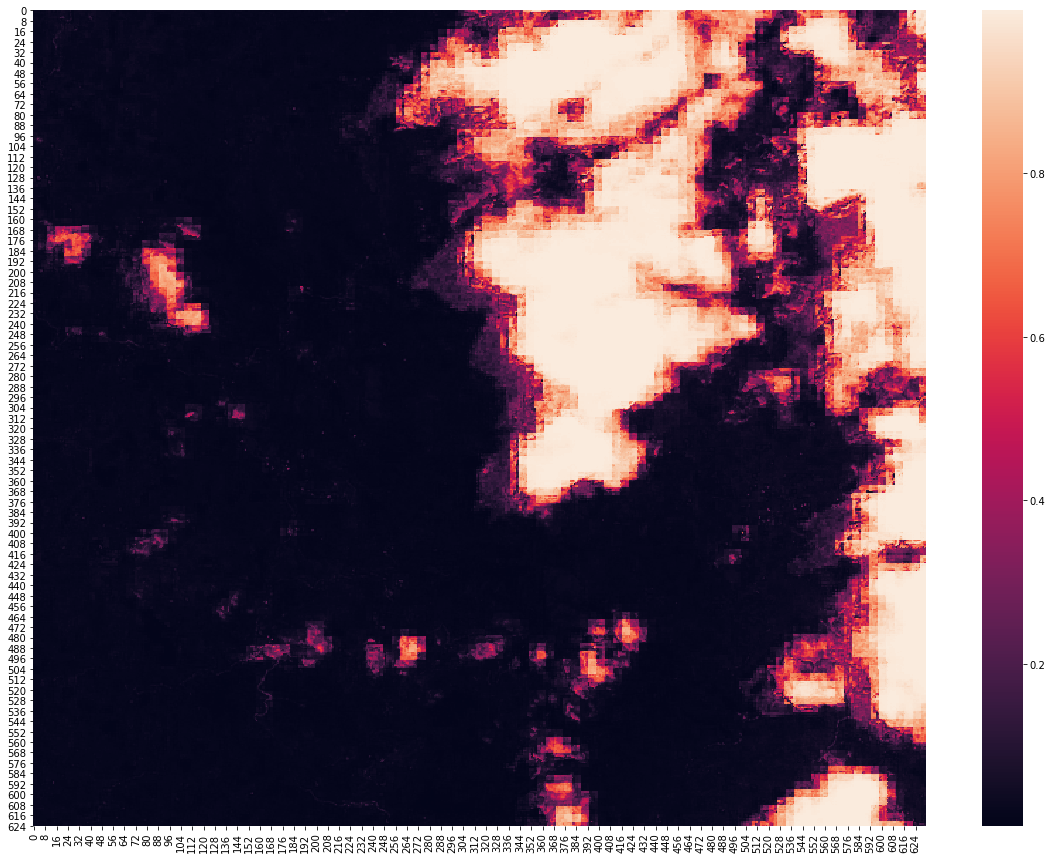

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 15))


#clouds = np.load(OUTPUT_FOLDER + "raw/clouds/clouds_0_2.npy")
sns.heatmap(clouds[38, :, :])

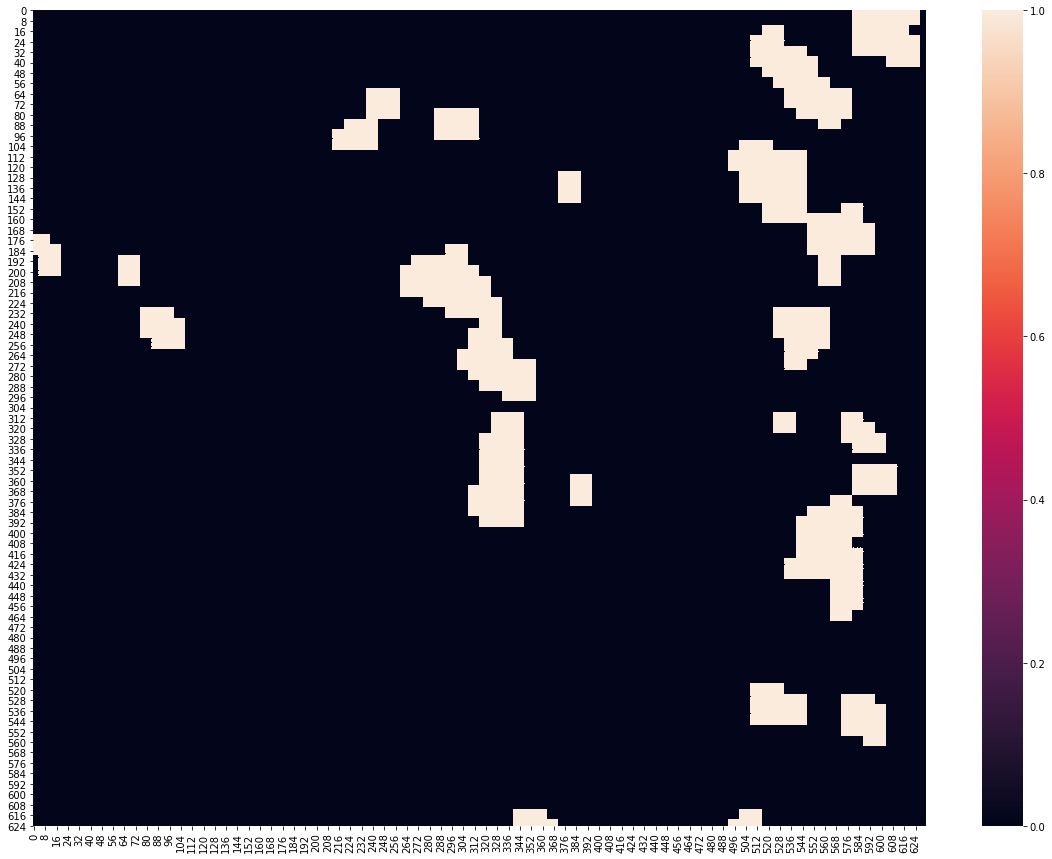

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 15))


#shadows = np.load(OUTPUT_FOLDER + "raw/clouds/shadows_0_2.npy")
sns.heatmap(shadows[38, :, :])

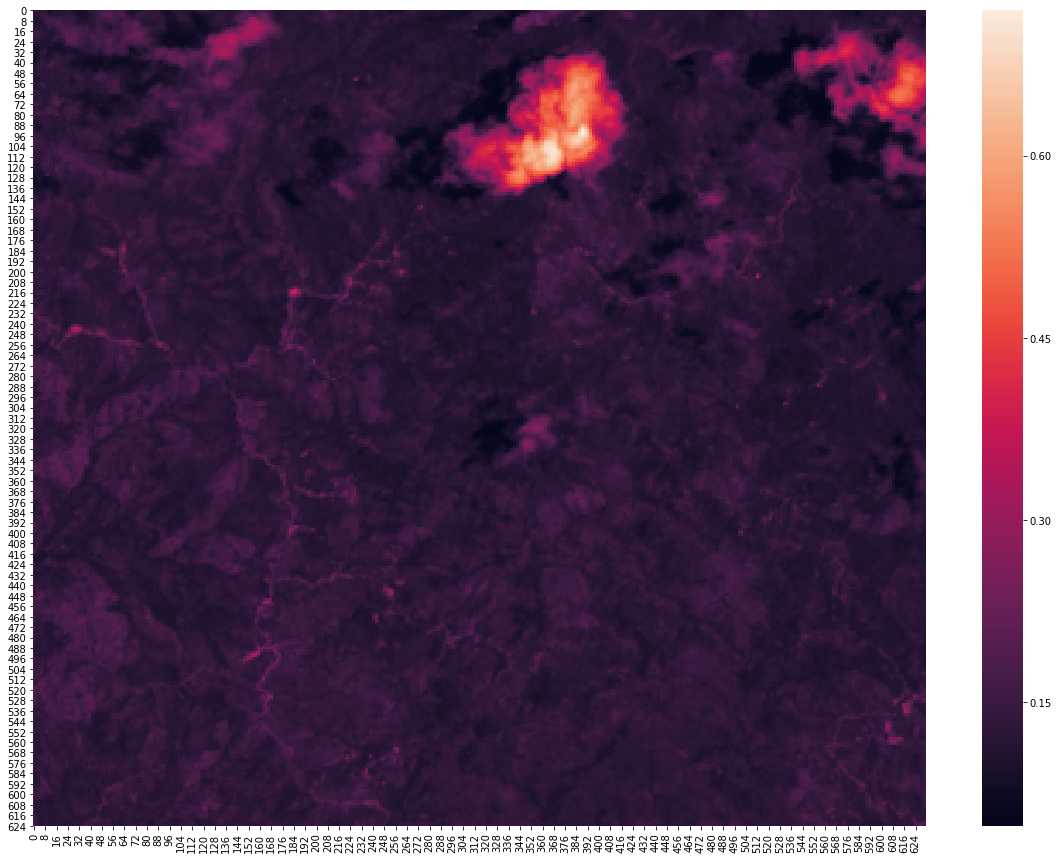

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 15))


#x = np.load(OUTPUT_FOLDER + "raw/clouds/l1c_0_2.npy")
sns.heatmap(x[25, :, :, 3])

In [18]:
def find_and_make_dirs(dirs):
    if not os.path.exists(os.path.realpath(dirs)):
        os.makedirs(os.path.realpath(dirs))

def make_output_and_temp_folders(idx, output_folder = OUTPUT_FOLDER):
    find_and_make_dirs(output_folder + "raw/")
    find_and_make_dirs(output_folder + "raw/clouds/")
    find_and_make_dirs(output_folder + "raw/s1/")
    find_and_make_dirs(output_folder + "raw/s2/")
    find_and_make_dirs(output_folder + "raw/misc/")
    find_and_make_dirs(output_folder + "processed/")

def download_large_tile(coord, step_x, step_y, folder = OUTPUT_FOLDER, year = 2019):
    '''
    Ideally the folder structure should be as follows:
     - Raw
         - Cloud
              - Y*5, X*5
         - Sentinel 1
         - Sentinel 2
         - DEM
         - Dates
     - Processed
         - Y, X
         
    Methodological questions to address:
        - Should we download all images for a region first, and then process?     - Seems unnecessary
          This would allow for matching up the borders
        - Remove dirty steps for the whole tile or by subtiles 
        - Is this the proper time to address the interpolation of clouds (?)
        - Make sure that cloud shadows line up with clouds                        - X
        - Make sure that sentinel 1 is properly matched up and items are removed  - X
         
    The strategy is as follows:
        - Download 5*9 by 5*9 cloud, S1, S2, DEM, dates, save to folders          - X
        - Load each start:start+128 tile                                          - X
        - Remove dirty steps, missing images, missed clouds, ratios               - X
        - Superresolve                                                            - X
        - Indices                                                                 - X
        - Calculate_and_save_best_images                                          - X
        - Whittaker smooth                                                        - X
        - Fuse S1
        - Save to processed / y / x
        - Iterate for each of the large sub-tiles
    
    '''
    print(coord)
    bbx = calculate_bbx(coord, step_x, step_y, expansion = 10)
    print(bbx)
    dem_bbx = calculate_bbx(coord, step_x, step_y, expansion = 20)
    idx = str(step_y) + "_" + str(step_x)
    print(idx)
    idx = str(idx)
    #if 1 != 0:
    print("Making raw folders")
    make_output_and_temp_folders(idx)

    print("Calculating cloud cover")
    if not os.path.exists(folder + "raw/clouds/clouds_{}.npy".format(idx)):
        l1c, cloud_probs, shadows = identify_clouds(bbx) # integrate cloud shadow here
        np.save(folder + "raw/clouds/clouds_{}.npy".format(idx), cloud_probs)
        np.save(folder + "raw/clouds/shadows_{}.npy".format(idx), shadows)

    if not os.path.exists(folder + "raw/s1/{}.npy".format(idx)):
        print("Downloading S1")
        s1, s1_dates = download_sentinel_1(bbx, layer = "SENT")
        s1 = process_sentinel_1_tile(s1, s1_dates)
        np.save(folder + "raw/s1/{}.npy".format(idx), s1)
        np.save(folder + "raw/misc/s1_dates_{}".format(idx), np.array(s1_dates))

    if not os.path.exists(folder + "raw/s2/{}.npy".format(idx)):
        print("Downloading S2")
        s2, s2_dates = download_layer(bbx)
        np.save(folder + "raw/s2/{}.npy".format(idx), s2)
        np.save(folder + "raw/misc/s2_dates_{}".format(idx), np.array(s2_dates))
        #np.save(folder + "raw/clouds/shadows_{}".format(idx), np.array(shadows))

    if not os.path.exists(folder + "raw/misc/dem_{}.npy".format(idx)):
        print("Downloading DEM")
        dem = download_dem(dem_bbx) # get the DEM BBOX
        np.save(folder + "raw/misc/dem_{}.npy".format(idx), dem)


In [19]:
def calculate_bad_steps(sentinel2, clouds):
    n_cloud_px = np.array([len(np.argwhere(clouds[x, :, :].reshape((632)*(632)) > 0.3)) for x in range(clouds.shape[0])])
    cloud_steps = np.argwhere(n_cloud_px > 632**2 / 5)
    missing_images = [np.argwhere(sentinel2[x, :, : :].flatten() == 0.0) for x in range(sentinel2.shape[0])]
    missing_images = np.array([len(x) for x in missing_images])
    missing_images_p = [np.argwhere(sentinel2[x, :, : :10].flatten() >= 1) for x in range(sentinel2.shape[0])]
    missing_images_p = np.array([len(x) for x in missing_images_p])
    missing_images += missing_images_p
    missing_images = np.argwhere(missing_images >= 100)
    print(cloud_steps)
    print(missing_images)
    #perc_shadow_px = np.sum(shadows, axis = (1, 2) / (79**2))
    #shadow_steps = np.argwhere(perc_shadow_px > 20)
    to_remove = np.unique(np.concatenate([cloud_steps.flatten(), missing_images.flatten()]))#, shadow_steps]))
    return to_remove

def superresolve(sentinel2):
    d10 = sentinel2[:, :, :, 0:4]
    d20 = sentinel2[:, :, :, 4:10]

    d10 = np.swapaxes(d10, 1, -1)
    d10 = np.swapaxes(d10, 2, 3)
    d20 = np.swapaxes(d20, 1, -1)
    d20 = np.swapaxes(d20, 2, 3)
    superresolved = DSen2(d10, d20)
    superresolved = np.swapaxes(superresolved, 1, -1)
    superresolved = np.swapaxes(superresolved, 1, 2)

    # returns band IDXs 3, 4, 5, 7, 8, 9
    return superresolved

def process_sentinel_1_tile(sentinel1, dates):
    s1 = calculate_and_save_best_images(sentinel1, dates)
    # Retain only iamgery every 15 days
    biweekly_dates = np.array([day for day in range(0, 360, 5)])
    to_remove = np.argwhere(biweekly_dates % 15 != 0)
    s1 = np.delete(s1, to_remove, 0)
    return s1


def interpolate_array(x):
    no_dem = np.delete(x, 10, -1)
    no_dem = np.reshape(no_dem, (72, 128*128*14))
    no_dem = np.swapaxes(no_dem, 0, 1)

    pool = multiprocessing.Pool(6)
    no_dem = pool.map(smooth, no_dem)
    pool.close()
    pool.join()

    no_dem = np.swapaxes(no_dem, 0, 1)
    no_dem = np.reshape(no_dem, (72, 128, 128, 14))
    x[:, :, :, :10] = no_dem[:, :, :, :10]
    x[:, :, :, 11:] = no_dem[:, :, :, 10:]

    biweekly_dates = np.array([day for day in range(0, 360, 5)])
    to_remove = np.argwhere(biweekly_dates % 15 != 0)
    x = np.delete(x, to_remove, 0)
    return x

def process_large_tile(step_x, step_y, folder = OUTPUT_FOLDER):
    idx = str(step_y) + "_" + str(step_x)
    x_vals = []
    y_vals = []
    # save to disk
    for i in range(25):
        y_val = (24 - i) // 5
        x_val = 5 - ((25 - i) % 5)
        x_val = 0 if x_val == 5 else x_val
        x_vals.append(x_val)
        y_vals.append(y_val)
        
    y_vals = [i + (5*step_y) for i in y_vals]
    x_vals = [i + (5*step_x) for i in x_vals]
    print(y_vals, x_vals)
    
    
    processed = True
    for x, y in zip(x_vals, y_vals):
        if not os.path.exists(folder + "processed/{}/{}.npy".format(str(y), str(x))):
            processed = False
    if not processed:
        
        clouds = np.load(folder + "raw/clouds/clouds_{}.npy".format(idx))
        sentinel1 = np.load(folder + "raw/s1/{}.npy".format(idx))
        radar_dates = np.load(folder + "raw/misc/s1_dates_{}.npy".format(idx))
        sentinel2 = np.load(folder + "raw/s2/{}.npy".format(idx))
        dem = np.load(folder + "raw/misc/dem_{}.npy".format(idx))
        image_dates = np.load(folder + "raw/misc/s2_dates_{}.npy".format(idx))
        if os.path.exists(folder + "raw/clouds/shadows_{}.npy".format(idx)):
            shadows = np.load(folder + "raw/clouds/shadows_{}.npy".format(idx))
        else:
            print("No shadows file, so calculating shadows with L2A")
            shadows = mcm_shadow_mask(sentinel2, clouds)
        print("The files have been loaded")

        #sentinel1 = process_sentinel_1_tile(sentinel1, radar_dates)
        to_remove = calculate_bad_steps(sentinel2, clouds)
        sentinel2 = np.delete(sentinel2, to_remove, axis = 0)
        clouds = np.delete(clouds, to_remove, axis = 0)
        shadows = np.delete(shadows, to_remove, axis = 0)
        image_dates = np.delete(image_dates, to_remove)
        print("Cloudy and missing images removed, radar processed")

        to_remove = remove_missed_clouds(sentinel2)
        sentinel2 = np.delete(sentinel2, to_remove, axis = 0)
        clouds = np.delete(clouds, to_remove, axis = 0)
        image_dates = np.delete(image_dates, to_remove)
        shadows = np.delete(shadows, to_remove, axis = 0)
        print("Missed cloudy images removed")

        x, _, _ = remove_cloud_and_shadows(sentinel2, clouds, shadows, image_dates)
        print("Clouds and shadows interpolated")


        index = 0
        for start_x, end_x in zip(range(0, 633, 126), range(128, 633, 126)):
            for start_y, end_y in zip(range(0, 633, 126), range(128, 633, 126)):
                print(index)
                if not os.path.exists(folder + "processed/{}/{}.npy".format(str(y_vals[index]), str(x_vals[index]))):
                    subtile = x[:, start_x:end_x, start_y:end_y, :]
                    resolved = superresolve(subtile)
                    subtile[:, :, :, 4:10] = resolved
                    dem_i = np.tile(dem[np.newaxis, start_x:end_x, start_y:end_y, :], (x.shape[0], 1, 1, 1))
                    subtile = np.concatenate([subtile, dem_i / 90], axis = -1)
                    subtile, amin = evi(subtile, verbose = True)
                    subtile = bi(subtile, verbose = True)
                    subtile = msavi2(subtile, verbose = True)
                    subtile = si(subtile, verbose = True)

                    subtile = calculate_and_save_best_images(subtile, image_dates)
                    subtile = interpolate_array(subtile)
                    subtile = np.concatenate([subtile, sentinel1[:, start_x:end_x,
                                                                start_y:end_y, :]], axis = -1)


                    out_y_folder = folder + "processed/{}/".format(str(y_vals[index]))
                    if not os.path.exists(os.path.realpath(out_y_folder)):
                        os.makedirs(os.path.realpath(out_y_folder))
                    np.save(folder + "processed/{}/{}.npy".format(str(y_vals[index]), str(x_vals[index])), subtile)
                index += 1
            
def clean_up_folders():
    pass

In [20]:
from tqdm import tnrange, tqdm_notebook

for x_tile in range(0, 5):
    for y_tile in range(0, 6):
        print("X: {} Y:{}".format(x_tile, y_tile))
        download_large_tile(coords, x_tile, y_tile)
        process_large_tile(x_tile, y_tile)
        #clean_up_folders(x_tile, y_tile)

X: 0 Y:0
(-88.720304, 14.096664)
([-88.66228796266806, 14.154104354883811], [-88.7203959199568, 14.096572960609123])
0_0
Making raw folders
Calculating cloud cover
[4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0] [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4]
X: 0 Y:1
(-88.720304, 14.096664)
([-88.66270297920144, 14.211043954913864], [-88.72082362514514, 14.153511117151329])
1_0
Making raw folders
Calculating cloud cover
[9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5] [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4]
X: 0 Y:2
(-88.720304, 14.096664)
([-88.66311983599344, 14.26798327246343], [-88.72125323304212, 14.210448991437888])
2_0
Making raw folders
Calculating cloud cover
[14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10] [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4]
X: 0 Y:3
(-88.720304, 14.0


Cloud probs: (69, 632, 632)
Maximum time distance: 25
Original size: (69, 640, 627, 6)
Original 10 size: (69, 640, 627, 4)
[24, 24, 24, 24, 24, 23, 23, 23, 23, 23, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 20, 20, 20, 20, 20] [5, 6, 7, 8, 9, 5, 6, 7, 8, 9, 5, 6, 7, 8, 9, 5, 6, 7, 8, 9, 5, 6, 7, 8, 9]
The files have been loaded
[[ 0]
 [ 6]
 [ 8]
 [ 9]
 [20]
 [24]
 [30]
 [37]
 [49]
 [52]
 [54]
 [55]
 [59]
 [63]
 [64]
 [67]
 [68]]
[[ 1]
 [ 4]
 [ 6]
 [ 8]
 [12]
 [13]
 [15]
 [24]
 [27]
 [29]
 [30]
 [37]
 [39]
 [42]
 [46]
 [49]
 [59]
 [61]
 [63]
 [66]
 [67]
 [68]]
Cloudy and missing images removed, radar processed
Missed cloudy images removed



A total of 152074 pixels were interpolated
Clouds and shadows interpolated
0
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
40/40 [==============================] - 25s 613ms/step
There are: 0 out of bounds EVI
Maximum time distance: 25
1
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
40/40 [==============================] - 23s 583ms/step
There are: 0 out of bounds EVI
()
evis error: -0.06922458857297897, 1.0340945720672607, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 25
2
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
40/40 [==============================] - 23s 586ms/step
There are: 0 out of bounds EVI
Maximum time distance: 25
3
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
40/40 [==============================] - 24s 593ms/step
There are: 2 out of bounds EVI
()
evis error: -18.63538932800293, 2.9635801315307617, 2 steps, clipping to -1.5, 1.5
Maximum time distance: 25
4
Predicting using file: ../src/ds


Cloud probs: (69, 632, 632)
Maximum time distance: 25
Original size: (69, 640, 627, 6)
Original 10 size: (69, 640, 627, 4)
[29, 29, 29, 29, 29, 28, 28, 28, 28, 28, 27, 27, 27, 27, 27, 26, 26, 26, 26, 26, 25, 25, 25, 25, 25] [5, 6, 7, 8, 9, 5, 6, 7, 8, 9, 5, 6, 7, 8, 9, 5, 6, 7, 8, 9, 5, 6, 7, 8, 9]
The files have been loaded
[[ 0]
 [ 1]
 [ 4]
 [ 6]
 [ 8]
 [ 9]
 [13]
 [15]
 [16]
 [20]
 [22]
 [24]
 [27]
 [29]
 [30]
 [37]
 [39]
 [42]
 [52]
 [53]
 [54]
 [55]
 [56]
 [59]
 [63]
 [64]
 [66]
 [67]
 [68]]
[[ 1]
 [ 6]
 [ 8]
 [ 9]
 [13]
 [15]
 [22]
 [24]
 [26]
 [27]
 [29]
 [31]
 [42]
 [46]
 [53]
 [59]
 [61]
 [63]
 [64]
 [66]
 [67]
 [68]]
Cloudy and missing images removed, radar processed
Missed cloudy images removed



A total of 238708 pixels were interpolated
Clouds and shadows interpolated
0
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
36/36 [==============================] - 24s 658ms/step
There are: 0 out of bounds EVI
()
evis error: -0.010983831249177456, 1.9963040351867676, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 45
1
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
36/36 [==============================] - 23s 652ms/step
There are: 2 out of bounds EVI
()
evis error: -4.424635887145996, 5.46810245513916, 2 steps, clipping to -1.5, 1.5
Maximum time distance: 45
2
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
36/36 [==============================] - 24s 655ms/step
There are: 0 out of bounds EVI
Maximum time distance: 45
3
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
36/36 [==============================] - 23s 631ms/step
There are: 0 out of bounds EVI
Maximum time distance: 45
4
Predicting using file: ../src/dse

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


23
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
36/36 [==============================] - 21s 594ms/step
There are: 1 out of bounds EVI
()
evis error: -4.201707363128662, 2.2596352100372314, 1 steps, clipping to -1.5, 1.5
Maximum time distance: 45
24
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
36/36 [==============================] - 21s 595ms/step
There are: 4 out of bounds EVI
()
evis error: -11.859992980957031, 4.228028297424316, 2 steps, clipping to -1.5, 1.5
Maximum time distance: 45
X: 2 Y:0
(-88.720304, 14.096664)
([-88.54557894780217, 14.154884153861472], [-88.60371959597359, 14.097377797641663])
0_2
Making raw folders
Calculating cloud cover
[4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0] [10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14]
X: 2 Y:1
(-88.720304, 14.096664)
([-88.5459648554358, 14.211827018129725], [-88.60411832584808, 14.154319335795412])
1_2
Makin


Cloud probs: (64, 632, 632)
Maximum time distance: 25
Original size: (64, 640, 627, 6)
Original 10 size: (64, 640, 627, 4)
[19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15] [10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14]
The files have been loaded
[[ 0]
 [ 4]
 [ 6]
 [ 8]
 [ 9]
 [13]
 [15]
 [17]
 [20]
 [22]
 [23]
 [24]
 [27]
 [28]
 [35]
 [37]
 [38]
 [41]
 [44]
 [47]
 [49]
 [50]
 [51]
 [58]
 [59]
 [61]
 [63]]
[[ 4]
 [ 6]
 [ 8]
 [ 9]
 [13]
 [15]
 [17]
 [22]
 [23]
 [24]
 [25]
 [27]
 [28]
 [30]
 [34]
 [35]
 [37]
 [38]
 [40]
 [41]
 [42]
 [44]
 [49]
 [50]
 [51]
 [58]
 [61]
 [62]
 [63]]
Cloudy and missing images removed, radar processed
Missed cloudy images removed



A total of 257555 pixels were interpolated
Clouds and shadows interpolated
0
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
31/31 [==============================] - 19s 602ms/step
There are: 0 out of bounds EVI
Maximum time distance: 40
1
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
31/31 [==============================] - 19s 603ms/step
There are: 0 out of bounds EVI
()
evis error: 0.03829875588417053, 2.848066806793213, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 40
2
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
31/31 [==============================] - 18s 595ms/step
There are: 0 out of bounds EVI
Maximum time distance: 40
3
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
31/31 [==============================] - 18s 592ms/step
There are: 0 out of bounds EVI
()
evis error: 0.027295516803860664, 1.0619430541992188, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 40
4
Predicting using file: ../src/ds


Cloud probs: (69, 632, 632)
Maximum time distance: 25
Original size: (69, 640, 627, 6)
Original 10 size: (69, 640, 627, 4)
[24, 24, 24, 24, 24, 23, 23, 23, 23, 23, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 20, 20, 20, 20, 20] [10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14]
The files have been loaded
[[ 0]
 [ 1]
 [ 4]
 [ 6]
 [ 8]
 [ 9]
 [13]
 [15]
 [17]
 [20]
 [22]
 [24]
 [30]
 [37]
 [40]
 [49]
 [52]
 [53]
 [54]
 [55]
 [59]
 [61]
 [63]
 [64]
 [66]
 [67]
 [68]]
[[ 1]
 [ 4]
 [ 6]
 [ 8]
 [ 9]
 [13]
 [15]
 [17]
 [22]
 [23]
 [24]
 [25]
 [27]
 [28]
 [29]
 [30]
 [33]
 [37]
 [38]
 [39]
 [40]
 [42]
 [44]
 [46]
 [49]
 [50]
 [51]
 [53]
 [54]
 [56]
 [59]
 [61]
 [63]
 [66]
 [67]
 [68]]
Cloudy and missing images removed, radar processed
Missed cloudy images removed



A total of 292129 pixels were interpolated
Clouds and shadows interpolated
0
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
28/28 [==============================] - 17s 622ms/step
There are: 0 out of bounds EVI
Maximum time distance: 60
1
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
28/28 [==============================] - 17s 591ms/step
There are: 2 out of bounds EVI
()
evis error: -3.1877870559692383, 411.71612548828125, 2 steps, clipping to -1.5, 1.5
Maximum time distance: 60
2
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
28/28 [==============================] - 17s 590ms/step
There are: 0 out of bounds EVI
()
evis error: 0.07200716435909271, 1.7494404315948486, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 60
3
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
28/28 [==============================] - 17s 596ms/step
There are: 0 out of bounds EVI
()
evis error: -0.00352515559643507, 1.1031506061553955, 0 s

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:88: RuntimeWarning: divide by zero encountered in true_divide
  bis = (BLUE + RED - GREEN) / (BLUE + RED + GREEN)
/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:88: RuntimeWarning: invalid value encountered in true_divide
  bis = (BLUE + RED - GREEN) / (BLUE + RED + GREEN)


9
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
28/28 [==============================] - 17s 597ms/step
There are: 0 out of bounds EVI
()
evis error: -0.10203251242637634, 1.0323020219802856, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 60
10
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
28/28 [==============================] - 17s 596ms/step
There are: 0 out of bounds EVI
()
evis error: 0.0642906054854393, 1.08477783203125, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 60
11
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
28/28 [==============================] - 17s 597ms/step
There are: 1 out of bounds EVI
()
evis error: 0.018717244267463684, 9.481254577636719, 1 steps, clipping to -1.5, 1.5
Maximum time distance: 60
12
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
28/28 [==============================] - 17s 592ms/step
There are: 0 out of bounds EVI
()
evis error: 0.07735005766153336, 1.4407758712


Cloud probs: (69, 632, 632)
Maximum time distance: 25
Original size: (69, 640, 627, 6)
Original 10 size: (69, 640, 627, 4)
[29, 29, 29, 29, 29, 28, 28, 28, 28, 28, 27, 27, 27, 27, 27, 26, 26, 26, 26, 26, 25, 25, 25, 25, 25] [10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14]
The files have been loaded
[[ 0]
 [ 1]
 [ 3]
 [ 4]
 [ 6]
 [ 8]
 [ 9]
 [13]
 [15]
 [20]
 [22]
 [24]
 [26]
 [27]
 [29]
 [30]
 [31]
 [37]
 [38]
 [39]
 [40]
 [41]
 [42]
 [46]
 [49]
 [51]
 [52]
 [53]
 [54]
 [55]
 [56]
 [59]
 [61]
 [63]
 [64]
 [66]
 [67]
 [68]]
[[ 1]
 [ 3]
 [ 4]
 [ 6]
 [ 8]
 [ 9]
 [13]
 [15]
 [22]
 [24]
 [26]
 [27]
 [28]
 [29]
 [30]
 [31]
 [38]
 [40]
 [42]
 [46]
 [49]
 [51]
 [52]
 [53]
 [54]
 [56]
 [59]
 [61]
 [63]
 [64]
 [66]
 [67]
 [68]]
Cloudy and missing images removed, radar processed
Missed cloudy images removed



A total of 321153 pixels were interpolated
Clouds and shadows interpolated
0
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 606ms/step
There are: 0 out of bounds EVI
()
evis error: 0.03481288626790047, 1.3709168434143066, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 55
1
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 601ms/step
There are: 0 out of bounds EVI
()
evis error: 0.03787585347890854, 1.0486907958984375, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 55
2
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 597ms/step
There are: 0 out of bounds EVI
()
evis error: 0.025179129093885422, 2.5316457748413086, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 55
3
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 596ms/step
The

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


10
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 600ms/step
There are: 1 out of bounds EVI
()
evis error: -29.03663444519043, 2.732314109802246, 1 steps, clipping to -1.5, 1.5
Maximum time distance: 55
11
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 597ms/step
There are: 1 out of bounds EVI
()
evis error: -72.34021759033203, 1.2655744552612305, 1 steps, clipping to -1.5, 1.5
Maximum time distance: 55
12
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 596ms/step
There are: 0 out of bounds EVI
()
evis error: -0.06721541285514832, 2.2037715911865234, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 55
13
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 596ms/step
There are: 1 out of bounds EVI
()
evis error: -185.78582763671875, 1.524033784


Cloud probs: (64, 632, 632)
Maximum time distance: 25
Original size: (64, 639, 627, 6)
Original 10 size: (64, 639, 627, 4)
[4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0] [15, 16, 17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19]
The files have been loaded
[[ 2]
 [ 7]
 [ 8]
 [ 9]
 [12]
 [13]
 [15]
 [17]
 [22]
 [23]
 [24]
 [27]
 [28]
 [29]
 [30]
 [35]
 [37]
 [38]
 [40]
 [41]
 [42]
 [43]
 [44]
 [46]
 [47]
 [48]
 [49]
 [51]
 [53]
 [58]
 [59]
 [61]
 [63]]
[[ 1]
 [ 2]
 [ 4]
 [ 8]
 [ 9]
 [12]
 [13]
 [15]
 [17]
 [22]
 [23]
 [24]
 [27]
 [28]
 [29]
 [30]
 [35]
 [38]
 [40]
 [41]
 [42]
 [43]
 [44]
 [45]
 [46]
 [47]
 [48]
 [51]
 [53]
 [58]
 [61]
 [63]]
Cloudy and missing images removed, radar processed
Missed cloudy images removed



A total of 107233 pixels were interpolated
Clouds and shadows interpolated
0
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
28/28 [==============================] - 18s 631ms/step
There are: 0 out of bounds EVI
()
evis error: 0.011031970381736755, 2.376408815383911, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 70
1
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
28/28 [==============================] - 17s 595ms/step
There are: 1 out of bounds EVI
()
evis error: 0.020747333765029907, 4.150275707244873, 1 steps, clipping to -1.5, 1.5
Maximum time distance: 70
2
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
28/28 [==============================] - 18s 657ms/step
There are: 0 out of bounds EVI
Maximum time distance: 70
3
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
28/28 [==============================] - 19s 662ms/step
There are: 0 out of bounds EVI
()
evis error: -0.003824770450592041, 2.554314136505127, 0 s

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


7
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
28/28 [==============================] - 17s 594ms/step
There are: 0 out of bounds EVI
Maximum time distance: 70
8
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
28/28 [==============================] - 17s 596ms/step
There are: 0 out of bounds EVI
()
evis error: -1.4787710905075073, 1.283948302268982, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 70
9
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
28/28 [==============================] - 17s 596ms/step
There are: 0 out of bounds EVI
()
evis error: 0.010061776265501976, 1.5294077396392822, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 70
10
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
28/28 [==============================] - 17s 600ms/step
There are: 0 out of bounds EVI
()
evis error: -0.9794602394104004, 2.0056354999542236, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 70
11
Predicting using fi


Cloud probs: (64, 632, 632)
Maximum time distance: 25
Original size: (64, 639, 627, 6)
Original 10 size: (64, 639, 627, 4)
[9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5] [15, 16, 17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19]
The files have been loaded
[[ 4]
 [ 8]
 [ 9]
 [12]
 [13]
 [22]
 [23]
 [24]
 [25]
 [27]
 [28]
 [29]
 [35]
 [40]
 [41]
 [44]
 [46]
 [47]
 [49]
 [51]
 [58]
 [59]
 [61]
 [63]]
[[ 4]
 [ 8]
 [ 9]
 [12]
 [13]
 [17]
 [22]
 [23]
 [24]
 [25]
 [27]
 [28]
 [29]
 [35]
 [40]
 [44]
 [47]
 [49]
 [51]
 [53]
 [58]
 [61]
 [63]]
Cloudy and missing images removed, radar processed
Missed cloudy images removed



A total of 334558 pixels were interpolated
Clouds and shadows interpolated
0
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
38/38 [==============================] - 23s 609ms/step
There are: 0 out of bounds EVI
()
evis error: -0.8599197864532471, 1.6523571014404297, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 50
1
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
38/38 [==============================] - 22s 586ms/step
There are: 0 out of bounds EVI
()
evis error: -0.03869060054421425, 1.1759772300720215, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 50
2
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
38/38 [==============================] - 23s 600ms/step
There are: 1 out of bounds EVI
()
evis error: -5.719195365905762, 1.7005419731140137, 1 steps, clipping to -1.5, 1.5
Maximum time distance: 50
3
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
38/38 [==============================] - 24s 619ms/step
Ther


Cloud probs: (64, 632, 632)
Maximum time distance: 25
Original size: (64, 640, 627, 6)
Original 10 size: (64, 640, 627, 4)
[14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10] [15, 16, 17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19]
The files have been loaded
[[ 0]
 [ 4]
 [ 6]
 [ 8]
 [ 9]
 [12]
 [13]
 [15]
 [17]
 [20]
 [22]
 [23]
 [24]
 [25]
 [27]
 [28]
 [29]
 [35]
 [37]
 [40]
 [44]
 [46]
 [47]
 [48]
 [49]
 [51]
 [58]
 [59]
 [61]
 [63]]
[[ 4]
 [ 5]
 [ 6]
 [ 8]
 [ 9]
 [12]
 [13]
 [15]
 [17]
 [22]
 [23]
 [24]
 [25]
 [27]
 [28]
 [29]
 [35]
 [37]
 [40]
 [44]
 [46]
 [47]
 [48]
 [49]
 [51]
 [53]
 [58]
 [61]
 [63]]
Cloudy and missing images removed, radar processed
Missed cloudy images removed



A total of 531160 pixels were interpolated
Clouds and shadows interpolated
0
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
32/32 [==============================] - 21s 655ms/step
There are: 0 out of bounds EVI
()
evis error: -0.13478456437587738, 1.4319251775741577, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 50
1
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
32/32 [==============================] - 21s 661ms/step
There are: 0 out of bounds EVI
()
evis error: 0.06508567184209824, 1.6621606349945068, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 50
2
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
32/32 [==============================] - 21s 646ms/step
There are: 0 out of bounds EVI
()
evis error: 0.048254720866680145, 1.203375220298767, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 50
3
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
32/32 [==============================] - 21s 649ms/step
The

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


4
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
32/32 [==============================] - 19s 593ms/step
There are: 3 out of bounds EVI
()
evis error: -20.47751235961914, 5.117490291595459, 1 steps, clipping to -1.5, 1.5
Maximum time distance: 50
5
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
32/32 [==============================] - 19s 601ms/step
There are: 0 out of bounds EVI
()
evis error: -0.15343846380710602, 1.1282365322113037, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 50
6
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
32/32 [==============================] - 19s 593ms/step
There are: 0 out of bounds EVI
()
evis error: 0.06408216059207916, 1.0896542072296143, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 50
7
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
32/32 [==============================] - 19s 600ms/step
There are: 1 out of bounds EVI
()
evis error: -2.1369574069976807, 4.914034366607


Cloud probs: (64, 632, 632)
Maximum time distance: 25
Original size: (64, 640, 627, 6)
Original 10 size: (64, 640, 627, 4)
[19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15] [15, 16, 17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19]
The files have been loaded
[[ 0]
 [ 1]
 [ 4]
 [ 6]
 [ 8]
 [ 9]
 [12]
 [13]
 [15]
 [20]
 [22]
 [23]
 [24]
 [27]
 [28]
 [29]
 [30]
 [35]
 [37]
 [38]
 [44]
 [46]
 [47]
 [48]
 [49]
 [50]
 [58]
 [59]
 [61]
 [62]
 [63]]
[[ 6]
 [ 8]
 [ 9]
 [13]
 [15]
 [16]
 [17]
 [22]
 [23]
 [24]
 [27]
 [28]
 [29]
 [35]
 [37]
 [38]
 [40]
 [44]
 [46]
 [47]
 [48]
 [49]
 [50]
 [58]
 [59]
 [61]
 [62]
 [63]]
Cloudy and missing images removed, radar processed
Missed cloudy images removed



A total of 366911 pixels were interpolated
Clouds and shadows interpolated
0
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 604ms/step
There are: 0 out of bounds EVI
()
evis error: -0.7088919878005981, 1.5785921812057495, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 60
1
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 602ms/step
There are: 0 out of bounds EVI
Maximum time distance: 60
2
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 590ms/step
There are: 0 out of bounds EVI
Maximum time distance: 60


/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


3
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 593ms/step
There are: 0 out of bounds EVI
()
evis error: 0.05401097238063812, 1.0278359651565552, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 60
4
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 593ms/step
There are: 0 out of bounds EVI
Maximum time distance: 60
5
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 591ms/step
There are: 1 out of bounds EVI
()
evis error: -0.7088919878005981, 4.098487854003906, 1 steps, clipping to -1.5, 1.5
Maximum time distance: 60
6
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 594ms/step
There are: 0 out of bounds EVI
Maximum time distance: 60
7
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 


Cloud probs: (69, 632, 632)
Maximum time distance: 25
Original size: (69, 640, 627, 6)
Original 10 size: (69, 640, 627, 4)
[24, 24, 24, 24, 24, 23, 23, 23, 23, 23, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 20, 20, 20, 20, 20] [15, 16, 17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19]
The files have been loaded
[[ 0]
 [ 1]
 [ 4]
 [ 6]
 [ 8]
 [ 9]
 [13]
 [15]
 [17]
 [20]
 [22]
 [23]
 [24]
 [28]
 [30]
 [31]
 [37]
 [40]
 [49]
 [51]
 [52]
 [53]
 [54]
 [55]
 [59]
 [61]
 [63]
 [64]
 [66]
 [67]
 [68]]
[[ 4]
 [ 6]
 [ 8]
 [ 9]
 [13]
 [15]
 [17]
 [22]
 [23]
 [24]
 [27]
 [28]
 [29]
 [30]
 [31]
 [37]
 [39]
 [40]
 [42]
 [44]
 [46]
 [49]
 [51]
 [52]
 [54]
 [61]
 [63]
 [64]
 [66]
 [67]
 [68]]
Cloudy and missing images removed, radar processed
Missed cloudy images removed



A total of 291179 pixels were interpolated
Clouds and shadows interpolated
0
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
32/32 [==============================] - 19s 607ms/step
There are: 0 out of bounds EVI
()
evis error: 0.02674926072359085, 1.0589872598648071, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 50
1
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
32/32 [==============================] - 19s 601ms/step
There are: 0 out of bounds EVI
()
evis error: 0.03489832207560539, 1.0353060960769653, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 50
2
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
32/32 [==============================] - 19s 608ms/step
There are: 2 out of bounds EVI
()
evis error: -0.10327444970607758, 11.116989135742188, 2 steps, clipping to -1.5, 1.5
Maximum time distance: 50
3
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
32/32 [==============================] - 21s 656ms/step
The

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


23
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
32/32 [==============================] - 19s 607ms/step
There are: 0 out of bounds EVI
()
evis error: 0.04001108929514885, 1.1253128051757812, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 50
24
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
32/32 [==============================] - 19s 601ms/step
There are: 0 out of bounds EVI
()
evis error: 0.013648979365825653, 1.4219977855682373, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 50
X: 3 Y:5
(-88.720304, 14.096664)
([-88.48909508121018, 14.439972019565989], [-88.54731705348817, 14.38247194062223])
5_3
Making raw folders
Calculating cloud cover
43



Cloud probs: (69, 632, 632)
Maximum time distance: 25
Original size: (69, 640, 627, 6)
Original 10 size: (69, 640, 627, 4)
[29, 29, 29, 29, 29, 28, 28, 28, 28, 28, 27, 27, 27, 27, 27, 26, 26, 26, 26, 26, 25, 25, 25, 25, 25] [15, 16, 17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19]
The files have been loaded
[[ 0]
 [ 1]
 [ 3]
 [ 4]
 [ 6]
 [ 8]
 [ 9]
 [13]
 [20]
 [22]
 [24]
 [26]
 [27]
 [28]
 [29]
 [30]
 [31]
 [37]
 [39]
 [40]
 [42]
 [49]
 [51]
 [52]
 [53]
 [55]
 [56]
 [59]
 [61]
 [62]
 [63]
 [64]
 [66]
 [67]
 [68]]
[[ 1]
 [ 3]
 [ 4]
 [ 6]
 [ 8]
 [ 9]
 [13]
 [15]
 [17]
 [22]
 [24]
 [26]
 [27]
 [28]
 [29]
 [30]
 [31]
 [37]
 [40]
 [42]
 [46]
 [49]
 [51]
 [52]
 [53]
 [54]
 [55]
 [59]
 [61]
 [62]
 [63]
 [64]
 [66]
 [67]
 [68]]
Cloudy and missing images removed, radar processed
Missed cloudy images removed



A total of 338564 pixels were interpolated
Clouds and shadows interpolated
0
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 19s 635ms/step
There are: 0 out of bounds EVI
()
evis error: 0.04339442402124405, 1.013935923576355, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 55
1
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 596ms/step
There are: 0 out of bounds EVI
()
evis error: -0.01095633115619421, 1.0011056661605835, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 55
2
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 611ms/step
There are: 2 out of bounds EVI
()
evis error: -8.162497520446777, 2.6180148124694824, 1 steps, clipping to -1.5, 1.5
Maximum time distance: 55
3
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 597ms/step
There

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


15
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 600ms/step
There are: 0 out of bounds EVI
Maximum time distance: 55
16
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 615ms/step
There are: 0 out of bounds EVI
Maximum time distance: 55
17
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 18s 599ms/step
There are: 0 out of bounds EVI
()
evis error: -1.4567420482635498, 2.413267135620117, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 55
18
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 19s 648ms/step
There are: 3 out of bounds EVI
()
evis error: -20.177366256713867, 4.289426803588867, 3 steps, clipping to -1.5, 1.5
Maximum time distance: 55
19
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 


Cloud probs: (64, 632, 632)
Maximum time distance: 25
Original size: (64, 639, 627, 6)
Original 10 size: (64, 639, 627, 4)
[4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0] [20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24]
The files have been loaded
[[ 4]
 [ 8]
 [12]
 [20]
 [22]
 [23]
 [27]
 [28]
 [35]
 [37]
 [44]
 [47]
 [58]
 [59]
 [63]]
[[ 1]
 [ 4]
 [ 8]
 [12]
 [13]
 [22]
 [23]
 [24]
 [27]
 [28]
 [29]
 [35]
 [37]
 [40]
 [41]
 [44]
 [47]
 [54]
 [58]
 [61]
 [63]]
Cloudy and missing images removed, radar processed
Missed cloudy images removed



A total of 159200 pixels were interpolated
Clouds and shadows interpolated
0
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
41/41 [==============================] - 24s 597ms/step
There are: 0 out of bounds EVI
()
evis error: 0.04511953145265579, 1.1762804985046387, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 50
1
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
41/41 [==============================] - 25s 609ms/step
There are: 0 out of bounds EVI
()
evis error: -0.16893315315246582, 1.348649024963379, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 50
2
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
41/41 [==============================] - 24s 593ms/step
There are: 0 out of bounds EVI
Maximum time distance: 50
3
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
41/41 [==============================] - 24s 589ms/step
There are: 0 out of bounds EVI
Maximum time distance: 50
4
Predicting using file: ../src/ds


Cloud probs: (64, 632, 632)
Maximum time distance: 25
Original size: (64, 639, 627, 6)
Original 10 size: (64, 639, 627, 4)
[9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5] [20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24]
The files have been loaded
[[ 4]
 [ 8]
 [ 9]
 [12]
 [20]
 [22]
 [27]
 [28]
 [35]
 [37]
 [40]
 [44]
 [59]
 [63]]
[[ 4]
 [ 8]
 [ 9]
 [12]
 [17]
 [22]
 [23]
 [25]
 [27]
 [28]
 [35]
 [40]
 [44]
 [58]
 [63]]
Cloudy and missing images removed, radar processed
Missed cloudy images removed



A total of 196142 pixels were interpolated
Clouds and shadows interpolated
0
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
46/46 [==============================] - 27s 594ms/step
There are: 3 out of bounds EVI
()
evis error: -7.669957160949707, 13.263370513916016, 3 steps, clipping to -1.5, 1.5
Maximum time distance: 40
1
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
46/46 [==============================] - 27s 580ms/step
There are: 0 out of bounds EVI
()
evis error: -1.984862208366394, 2.9688384532928467, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 40
2
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
46/46 [==============================] - 27s 582ms/step
There are: 0 out of bounds EVI
Maximum time distance: 40
3
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
46/46 [==============================] - 27s 584ms/step
There are: 1 out of bounds EVI
()
evis error: -2.3097915649414062, 39.868682861328125, 1 step

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


10
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
46/46 [==============================] - 27s 587ms/step
There are: 0 out of bounds EVI
Maximum time distance: 40
11
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
46/46 [==============================] - 27s 586ms/step
There are: 0 out of bounds EVI
()
evis error: -0.001770145259797573, 1.009452223777771, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 40
12
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
46/46 [==============================] - 27s 590ms/step
There are: 0 out of bounds EVI
()
evis error: 0.07037913054227829, 1.6820563077926636, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 40
13
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
46/46 [==============================] - 27s 586ms/step
There are: 0 out of bounds EVI
()
evis error: -1.641829013824463, 0.9745962023735046, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 40
14
Predicting using


Cloud probs: (64, 632, 632)
Maximum time distance: 25
Original size: (64, 639, 627, 6)
Original 10 size: (64, 639, 627, 4)
[14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10] [20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24]
The files have been loaded
[[ 0]
 [ 4]
 [ 6]
 [ 8]
 [ 9]
 [12]
 [13]
 [20]
 [22]
 [24]
 [27]
 [28]
 [30]
 [31]
 [35]
 [38]
 [40]
 [41]
 [44]
 [58]
 [59]
 [63]]
[[ 6]
 [ 8]
 [ 9]
 [12]
 [13]
 [17]
 [22]
 [24]
 [27]
 [28]
 [35]
 [37]
 [40]
 [41]
 [44]
 [51]
 [54]
 [63]]
Cloudy and missing images removed, radar processed
Missed cloudy images removed



A total of 237326 pixels were interpolated
Clouds and shadows interpolated
0
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
38/38 [==============================] - 23s 606ms/step
There are: 0 out of bounds EVI
Maximum time distance: 40
1
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
38/38 [==============================] - 22s 591ms/step
There are: 0 out of bounds EVI
Maximum time distance: 40
2
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
38/38 [==============================] - 22s 585ms/step
There are: 0 out of bounds EVI
()
evis error: -0.1435619443655014, 2.7134485244750977, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 40
3
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
38/38 [==============================] - 22s 589ms/step
There are: 0 out of bounds EVI
Maximum time distance: 40
4
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
38/38 [==============================] - 23s 594ms/step

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


12
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
38/38 [==============================] - 23s 593ms/step
There are: 8 out of bounds EVI
()
evis error: -44.786128997802734, 30.66129493713379, 7 steps, clipping to -1.5, 1.5
Maximum time distance: 40
13
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
38/38 [==============================] - 25s 647ms/step
There are: 0 out of bounds EVI
Maximum time distance: 40
14
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
38/38 [==============================] - 24s 619ms/step
There are: 0 out of bounds EVI
()
evis error: -0.10088498890399933, 2.2513999938964844, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 40
15
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
38/38 [==============================] - 23s 613ms/step
There are: 0 out of bounds EVI
Maximum time distance: 40
16
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
38/38 [==============================] 


Cloud probs: (64, 632, 632)
Maximum time distance: 25
Original size: (64, 639, 627, 6)
Original 10 size: (64, 639, 627, 4)
[19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15] [20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24]
The files have been loaded
[[ 0]
 [ 8]
 [ 9]
 [12]
 [13]
 [20]
 [22]
 [24]
 [27]
 [28]
 [31]
 [35]
 [37]
 [38]
 [41]
 [44]
 [49]
 [58]
 [59]
 [61]
 [62]
 [63]]
[[ 2]
 [ 8]
 [ 9]
 [13]
 [15]
 [17]
 [22]
 [24]
 [27]
 [38]
 [41]
 [44]
 [49]
 [59]
 [61]
 [63]]
Cloudy and missing images removed, radar processed
Missed cloudy images removed



A total of 473586 pixels were interpolated
Clouds and shadows interpolated
0
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
39/39 [==============================] - 23s 594ms/step
There are: 0 out of bounds EVI
Maximum time distance: 40
1
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
39/39 [==============================] - 23s 601ms/step
There are: 0 out of bounds EVI
()
evis error: -0.009032884612679482, 1.9842445850372314, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 40
2
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
39/39 [==============================] - 24s 620ms/step
There are: 0 out of bounds EVI
Maximum time distance: 40
3
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
39/39 [==============================] - 23s 587ms/step
There are: 0 out of bounds EVI
()
evis error: -0.20144593715667725, 1.1846381425857544, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 40
4
Predicting using file: ../src

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


15
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
39/39 [==============================] - 23s 590ms/step
There are: 0 out of bounds EVI
Maximum time distance: 40
16
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
39/39 [==============================] - 23s 591ms/step
There are: 0 out of bounds EVI
Maximum time distance: 40
17
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
39/39 [==============================] - 23s 594ms/step
There are: 0 out of bounds EVI
Maximum time distance: 40
18
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
39/39 [==============================] - 23s 591ms/step
There are: 0 out of bounds EVI
Maximum time distance: 40
19
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
39/39 [==============================] - 23s 597ms/step
There are: 0 out of bounds EVI
()
evis error: -0.11016318202018738, 2.020390272140503, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 40
20
Predicting


Cloud probs: (69, 632, 632)
Maximum time distance: 25
Original size: (69, 639, 627, 6)
Original 10 size: (69, 639, 627, 4)
[24, 24, 24, 24, 24, 23, 23, 23, 23, 23, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 20, 20, 20, 20, 20] [20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24]
The files have been loaded
[[ 0]
 [ 1]
 [ 4]
 [ 6]
 [ 8]
 [ 9]
 [13]
 [15]
 [17]
 [20]
 [22]
 [24]
 [28]
 [30]
 [31]
 [37]
 [49]
 [52]
 [55]
 [59]
 [61]
 [63]
 [64]
 [66]
 [67]
 [68]]
[[ 4]
 [ 6]
 [ 8]
 [ 9]
 [13]
 [15]
 [22]
 [24]
 [27]
 [28]
 [29]
 [30]
 [31]
 [32]
 [37]
 [39]
 [42]
 [44]
 [46]
 [49]
 [54]
 [61]
 [63]
 [64]
 [66]
 [67]
 [68]]
Cloudy and missing images removed, radar processed
Missed cloudy images removed



A total of 295505 pixels were interpolated
Clouds and shadows interpolated
0
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
35/35 [==============================] - 22s 627ms/step
There are: 2 out of bounds EVI
()
evis error: -1.7991197109222412, 17.517641067504883, 2 steps, clipping to -1.5, 1.5
Maximum time distance: 60
1
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
35/35 [==============================] - 20s 585ms/step
There are: 0 out of bounds EVI
()
evis error: 0.107429638504982, 1.0068830251693726, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 60
2
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
35/35 [==============================] - 20s 581ms/step
There are: 0 out of bounds EVI
()
evis error: -0.017573051154613495, 1.0535163879394531, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 60
3
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
35/35 [==============================] - 20s 584ms/step
Ther

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


4
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
35/35 [==============================] - 21s 586ms/step
There are: 3 out of bounds EVI
()
evis error: -0.03938620537519455, 6.882568359375, 3 steps, clipping to -1.5, 1.5
Maximum time distance: 60
5
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
35/35 [==============================] - 21s 589ms/step
There are: 0 out of bounds EVI
()
evis error: -0.11911281943321228, 1.404200792312622, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 60
6
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
35/35 [==============================] - 21s 591ms/step
There are: 0 out of bounds EVI
()
evis error: 0.05125340074300766, 1.024553894996643, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 60
7
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
35/35 [==============================] - 21s 598ms/step
There are: 1 out of bounds EVI
()
evis error: -16.487873077392578, 1.049183607101440


Cloud probs: (69, 632, 632)
Maximum time distance: 25
Original size: (69, 639, 627, 6)
Original 10 size: (69, 639, 627, 4)
[29, 29, 29, 29, 29, 28, 28, 28, 28, 28, 27, 27, 27, 27, 27, 26, 26, 26, 26, 26, 25, 25, 25, 25, 25] [20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24]
The files have been loaded
[[ 0]
 [ 1]
 [ 4]
 [ 6]
 [ 8]
 [13]
 [20]
 [22]
 [27]
 [28]
 [29]
 [30]
 [34]
 [37]
 [39]
 [40]
 [42]
 [46]
 [49]
 [51]
 [52]
 [53]
 [55]
 [56]
 [59]
 [61]
 [63]
 [64]
 [66]
 [67]
 [68]]
[[ 1]
 [ 4]
 [ 6]
 [ 8]
 [ 9]
 [13]
 [15]
 [22]
 [28]
 [29]
 [30]
 [42]
 [49]
 [53]
 [59]
 [61]
 [63]
 [64]
 [66]
 [67]
 [68]]
Cloudy and missing images removed, radar processed
Missed cloudy images removed



A total of 386498 pixels were interpolated
Clouds and shadows interpolated
0
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
36/36 [==============================] - 21s 596ms/step
There are: 0 out of bounds EVI
()
evis error: -1.2394206523895264, 1.512751579284668, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 40
1
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
36/36 [==============================] - 21s 589ms/step
There are: 0 out of bounds EVI
()
evis error: 0.06978629529476166, 1.2080473899841309, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 40
2
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
36/36 [==============================] - 21s 594ms/step
There are: 2 out of bounds EVI
()
evis error: -108.58323669433594, 2.997570276260376, 2 steps, clipping to -1.5, 1.5
Maximum time distance: 40
3
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
36/36 [==============================] - 21s 590ms/step
There 

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


10
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
36/36 [==============================] - 21s 597ms/step
There are: 0 out of bounds EVI
Maximum time distance: 40
11
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
36/36 [==============================] - 21s 594ms/step
There are: 0 out of bounds EVI
()
evis error: 0.033053919672966, 1.9766467809677124, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 40
12
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
36/36 [==============================] - 21s 594ms/step
There are: 4 out of bounds EVI
()
evis error: -132.6019287109375, 3.7631282806396484, 4 steps, clipping to -1.5, 1.5
Maximum time distance: 40
13
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
36/36 [==============================] - 21s 591ms/step
There are: 0 out of bounds EVI
Maximum time distance: 40
14
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
36/36 [==============================] - 2